The script for the interpretability of the predictions using Shapley values is given below. It can be serated in three main tasks:\
1) Importing the datasets and the neural network\
2) Calculating the Shapley values\
3) Calculating the correlations with the most important descriptors\
4) Visualizing the distribution of the descriptors on the labelled and the unlabelled datasets

# Import the libraries, datasets and the neural network

In [2]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import sys
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes'])

In [5]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache()
#torch.cuda.is_available() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet


/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src/set_transformer
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src


In [6]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'})

dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0

In [7]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [8]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [9]:
# Load the deep learning model
torch.manual_seed(0)

deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
net_name='model_checkpoint.pth'
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
deep_SVDD.load_model('/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/model_checkpoint_60_epochs.pth')

In [121]:
# Import the datasets

dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()
df1=dataset1.iloc[:,2:]
df1 = df1.fillna(df1.mean())
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(df2.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]

In [122]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict= {key:value for key, value in zip(k1, v1)}
print(dict['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [123]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset_1, dataset_2):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset_1, dataset_2], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset_2, dataset_1], axis=1) ])


In [124]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
df.head()

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
0     WOVMEB  0.012474  0.041630  ...            0.0           0.0           0.0
1     PIWKEL  0.070361  0.134320  ...            0.0           1.0           0.0
2     OTIHIJ  0.164308  0.066597  ...            0.0           0.0           0.0
3     DABLOJ  0.005860  0.051978  ...            0.0           0.0           0.0
4     PIGJUK  0.095382  0.159366  ...            0.0           0.0           0.0

[5 rows x 3715 columns]

In [14]:
# Import the scoring function of deepSVDD
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [15]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()

lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])

# Calculate the Shapley values

In [17]:
# Import the libraries
!pip install shap

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394132 sha256=04fd01d978f6fb796e1c3fc093e608740e5754bcda62f9e3375c6faa63e27a29
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [18]:
class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        #x = torch.FloatTensor(x).cpu().to(device)
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
        M= lab.max()
        m= lab.min()
        scores = (scores - m)/(M-m)
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [19]:
# Add the '_1' and '_2' at the end of each descriptor to denote the possition of the molecule in the vector
df1=dataset1.iloc[:,2:]
labels1 = df1.rename(columns=lambda x: f"{x}_1")
labels2 = df1.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values

cols = np.concatenate((dataset1_labels, dataset2_labels))

In [20]:
# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(df.iloc[:, 1:].values).to(device)
model = shapNet#.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(background, rseed=0, ranked_outputs=10)


In [33]:
pd.DataFrame(shap_values).iloc[:, :1857].values

0         1         2     ...      1854      1855      1856
0    -0.002947  0.001774  0.003256  ... -0.000590  0.001531 -0.000034
1     0.000853 -0.001549 -0.002540  ...  0.000455  0.011028 -0.009962
2    -0.001174 -0.000106 -0.000407  ... -0.000370  0.002311  0.000015
3    -0.003286 -0.000647  0.002213  ...  0.000033  0.000229 -0.000004
4     0.000066  0.000187 -0.001154  ...  0.000054  0.004221  0.000078
...        ...       ...       ...  ...       ...       ...       ...
3439  0.001222  0.000696  0.000300  ... -0.000268  0.001175  0.000499
3440  0.000691  0.000965  0.001802  ... -0.000682 -0.000214  0.000305
3441  0.000772  0.001466 -0.000998  ... -0.000677  0.004056  0.000226
3442 -0.000351 -0.001100  0.000916  ... -0.000203 -0.000567 -0.000137
3443  0.003994  0.000537  0.000768  ... -0.000339  0.001601  0.000640

[3444 rows x 1857 columns]

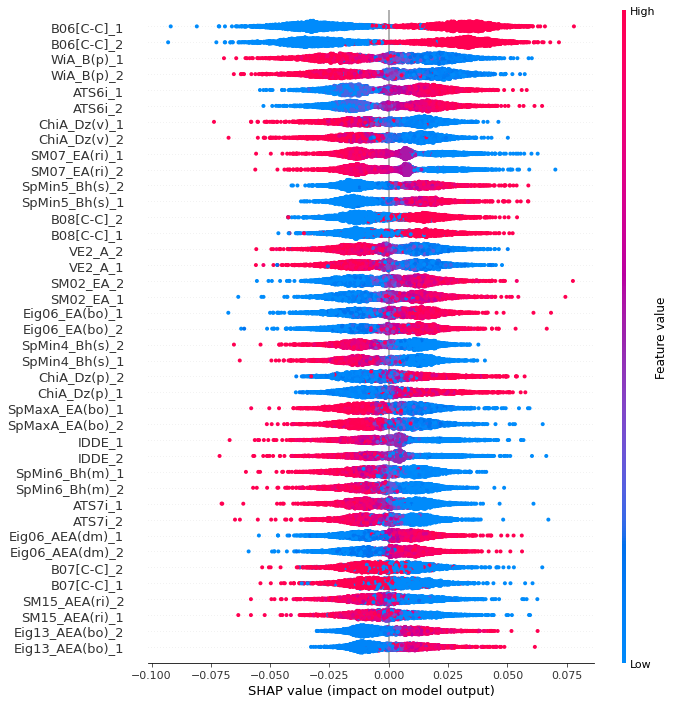

In [36]:
# Plot the most important features 

X = pd.DataFrame(df.iloc[:, 1:].values, columns=cols) 

shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=40,  show=False)

#plt.savefig('shap_lab.svg')  

In [62]:
%cd ..

/content/drive/My Drive/cocrystal_design/models


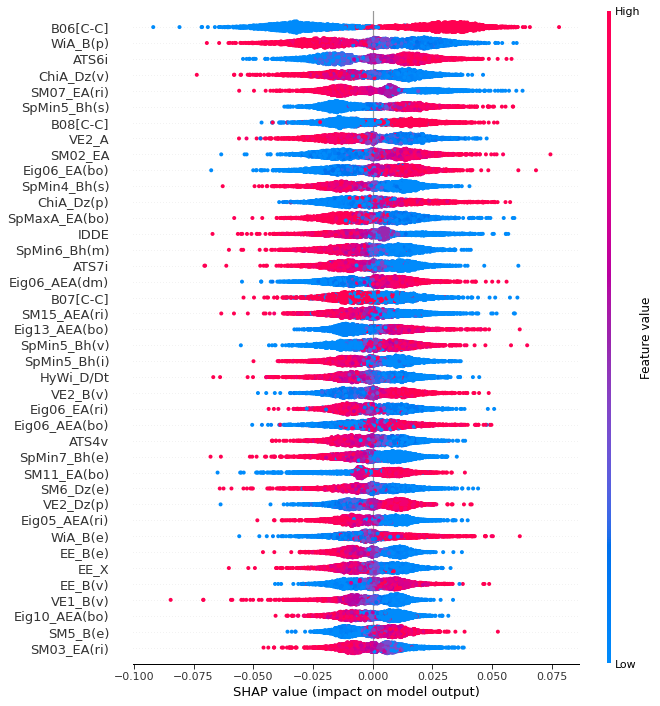

In [64]:
# Plot the most important features 

X = pd.DataFrame(df.iloc[:, 1:1858].values, columns=dataset1.columns.values[2:]) 

shap.summary_plot(pd.DataFrame(shap_values).iloc[:, :1857].values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=40,  show=False)

plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures_SI/shap_lab.svg')  


In [37]:
# Create a dataset with the labelled dataset Identifier and the shapley values for each of them. In that way we can select a subset among these and visualize the important descriptor for the subset of interest
# That could be for instance the pyrene co-crystals
dataset = pd.concat([pd.DataFrame(df.iloc[:, 0].values, columns=['Identifier']), pd.DataFrame(shap_values, columns=df.columns.values[1:]) ], axis=1)
dataset.head()

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
0     WOVMEB -0.002947  0.001774  ...      -0.000192      0.000350      0.000039
1     PIWKEL  0.000853 -0.001549  ...       0.000056      0.012875      0.000048
2     OTIHIJ -0.001174 -0.000106  ...      -0.000740      0.004083     -0.000002
3     DABLOJ -0.003286 -0.000647  ...      -0.000110      0.000604      0.000416
4     PIGJUK  0.000066  0.000187  ...      -0.000055      0.003786     -0.000335

[5 rows x 3715 columns]

In [38]:
# Select the pyrene co-crystals of the subset and place the pyrene molecule first in all tha cases such that we are going to be able to focus only on the features that characterize the pairing molecules

pyrene_cocrystals1 = dataset1[dataset1.NAME == 'c1cc2ccc3cccc4ccc(c1)c2c34']
pyrene_cocrystals2 = dataset2[dataset2.NAME == 'c1cc2ccc3cccc4ccc(c1)c2c34']
pyrene_cocrystals = pd.concat([pyrene_cocrystals1, pyrene_cocrystals2]).Identifier.values


In [40]:
pyr1 = dataset1[dataset1.Identifier.isin(pyrene_cocrystals)]
pyrene1 = pyr1[pyr1.NAME  == 'c1cc2ccc3cccc4ccc(c1)c2c34'].Identifier
pyr_switch = pyr1[pyr1.NAME  != 'c1cc2ccc3cccc4ccc(c1)c2c34'].Identifier
X = df[df.Identifier.isin(pyrene_cocrystals)]
pyrene1= X[X.Identifier.isin(pyrene1)]


In [41]:
shapley_labelled = pd.concat([pd.DataFrame(df.Identifier.values, columns=['Identifier']), pd.DataFrame(shap_values, columns=df.columns.values[1:])], axis=1)
#shapley_labelled = shapley_labelled[shapley_labelled.Identifier.isin(train_inl)]
#s_val = shapley_labelled.iloc[:,1:1858 ]


In [43]:
X = df[df.Identifier.isin(pyrene_cocrystals)]
py2 = shapley_labelled[shapley_labelled.Identifier.isin(pyr_switch)]
pyrene1= X[X.Identifier.isin(pyrene1)]
pyrene2  = pd.concat([py2.iloc[:,0] , py2.iloc[:, 1858:], py2.iloc[:, 1:1858]], axis=1)

In [44]:
pyr_switch
pyr2 = X[X.Identifier.isin(pyr_switch)]
pyr2.iloc[:, 1:]
pyrene2  = pd.concat([py2.iloc[:,0] , pyr2.iloc[:, 1858:], pyr2.iloc[:, 1:1858]], axis=1)


In [45]:
shapley_labelled = shapley_labelled[shapley_labelled.Identifier.isin(pyrene_cocrystals)]
shapley_labelled
pyrene1= shapley_labelled[shapley_labelled.Identifier.isin(pyrene1)]


In [46]:
# Pyrene molecule is set in position 2, so we are focusing on the constributions of the second coformer
pyrene_dataset = pd.concat([pyrene1, pyrene2], axis=0)
pyrene_dataset.head()

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
64     TUYVUF  0.047662  0.090883  ...       0.000000      0.000000      0.000000
84     AYEGAM  0.047662  0.090883  ...       0.029208      0.193697      0.033051
85     BAZCUA  0.047662  0.090883  ...       0.000000      0.000000      0.000000
86     BAZDAH  0.047662  0.090883  ...       0.000000      1.000000      1.000000
87     BORPII  0.047662  0.090883  ...       0.000000      0.000000      0.000000

[5 rows x 3715 columns]

In [126]:
# Interprete the Unlabelled Dataset

import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(pyrene_dataset.iloc[:, 1:].values).to(device)
model = shapNet 

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values_pyr = e.shap_values(background, rseed=0, ranked_outputs=20)


In [127]:

shapley_pyrene = pd.concat([pd.DataFrame(pyrene_dataset.Identifier.values, columns=['Identifier']), pd.DataFrame(shap_values_pyr, columns=df.columns.values[1:])], axis=1)
pyrene_coform = shapley_pyrene.iloc[:, 1858: ] #1858:

pyrene_coform.shape

(41, 1857)

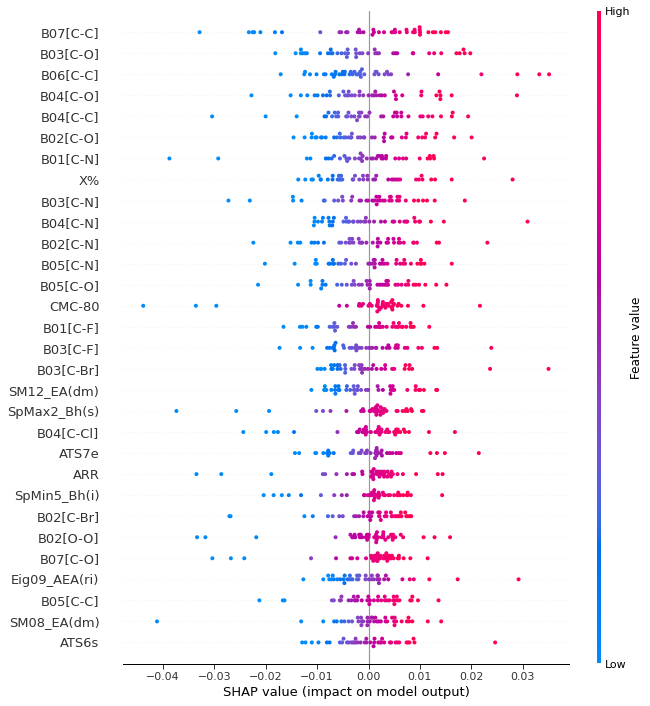

In [ ]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("paper", rc={"axes.labelsize":8} )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, aspect='equal')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
#X = pyrene_dataset.iloc[:, 1:] #pd.DataFrame(X_inl.iloc[:, 1:1858].values, columns=df.iloc[:, 1:1858].columns.values) 

X1 = pd.DataFrame(pyrene_coform.iloc[:, :].values, columns=pyrene_dataset.iloc[:, 1:1858].columns.values) 

shap.summary_plot(pyrene_coform.iloc[:, :].values , X1 ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=20, class_names=None, max_display=30,  show=False)

#plt.savefig('shap_pyr.svg')
#, color='r', axis_color="#333333", title=None, alpha=0.8, show=True, sort=True,
          #      

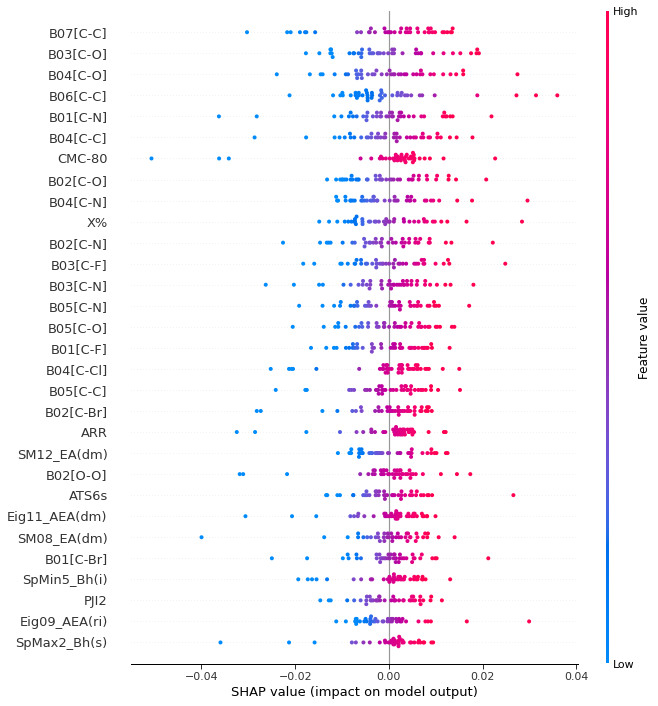

In [128]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("paper", rc={"axes.labelsize":8} )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, aspect='equal')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
#X = pyrene_dataset.iloc[:, 1:] #pd.DataFrame(X_inl.iloc[:, 1:1858].values, columns=df.iloc[:, 1:1858].columns.values) 

X1 = pd.DataFrame(pyrene_coform.iloc[:, :].values, columns=pyrene_dataset.iloc[:, 1:1858].columns.values) 

shap.summary_plot(pyrene_coform.iloc[:, :].values , X1 ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=20, class_names=None, max_display=30,  show=False)

#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures_SI/shap_pyr.svg')


In [129]:
# Interprete the Unlabelled Dataset

import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(pyrene_dataset.iloc[:, 1:].values).to(device) #df.iloc[:, 1:].values  #test.iloc[:, 1:]. #(uf_final.iloc[:,1:]  #uf.iloc[:, :].values
model = shapNet 

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)    

#e = shap.KernelExplainer(model, background)
shap_values_pyr = e.shap_values(background, rseed=1, ranked_outputs=20)


In [130]:

shapley_pyrene = pd.concat([pd.DataFrame(pyrene_dataset.Identifier.values, columns=['Identifier']), pd.DataFrame(shap_values_pyr, columns=df.columns.values[1:])], axis=1)
pyrene_coform = shapley_pyrene.iloc[:, 1858: ] 
pyrene_coform.shape

(41, 1857)

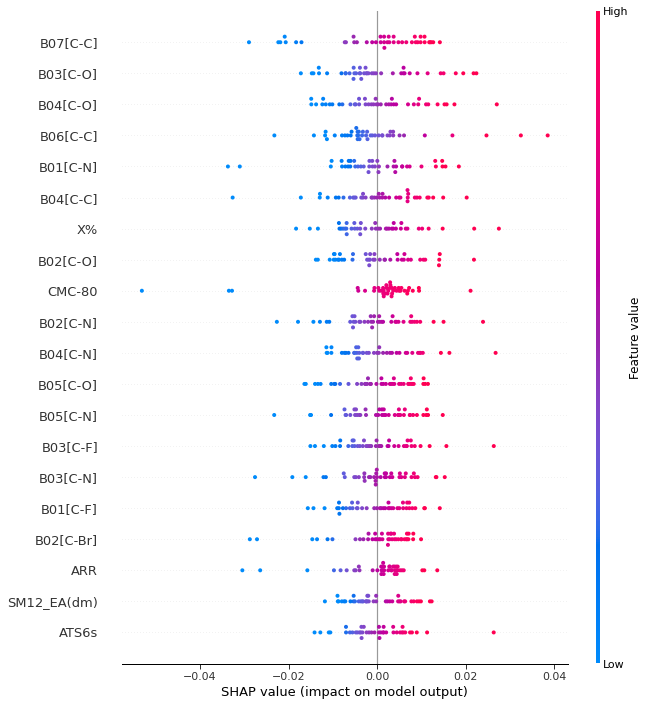

In [131]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("paper", rc={"axes.labelsize":8} )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, aspect='equal')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
#X = pyrene_dataset.iloc[:, 1:] #pd.DataFrame(X_inl.iloc[:, 1:1858].values, columns=df.iloc[:, 1:1858].columns.values) 

X1 = pd.DataFrame(pyrene_coform.iloc[:, :].values, columns=pyrene_dataset.iloc[:, 1:1858].columns.values) 

shap.summary_plot(pyrene_coform.iloc[:, :].values , X1 ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=20, class_names=None, max_display=20,  show=False)

#plt.savefig('shap_pyr.svg')
#, color='r', axis_color="#333333", title=None, alpha=0.8, show=True, sort=True,
          #      

# Connecting the most important Shapley values with understandable descriptors by calculating the correlation between them

In [50]:
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep=False)
print(df1_w.shape)
print(df2_w.shape)

# Create correlation matrix
corr_matrix1 = data_.corr(method='spearman').abs()
c1 = corr_matrix1.abs().unstack()

(1722, 1857)
(1722, 1857)


In [113]:
c1['Eig06_EA(bo)'].sort_values(ascending = False)[600:650] 

ATS8v            0.816186
ATS4v            0.816053
SAtot            0.816023
SM6_H2           0.815312
X0v              0.815226
SpMaxA_B(m)      0.814349
Eig04_AEA(bo)    0.814260
VE2_H2           0.814193
VE2_B(p)         0.813786
ATS1e            0.813212
SpMax7_Bh(i)     0.813111
VE2_B(m)         0.813067
X3sol            0.812807
SM04_EA          0.812678
Eig09_AEA(ed)    0.812292
Sp               0.811851
MWC07            0.811668
Eig05_AEA(ri)    0.811410
F09[C-C]         0.811347
Eig05_EA         0.810714
SM13_AEA(bo)     0.810714
SpMax7_Bh(p)     0.810624
EE_Dz(v)         0.810366
Eig11_AEA(dm)    0.809719
SpMin6_Bh(p)     0.809279
MPC06            0.808607
SpMAD_D          0.808382
SpPosA_D         0.808378
F08[C-C]         0.808251
SpMaxA_D         0.807983
VvdwZAZ          0.807863
ATS8m            0.807820
X2sol            0.806464
F05[C-C]         0.806357
ATS7v            0.806080
SpMin7_Bh(e)     0.805935
F06[C-C]         0.804832
SM02_EA(ed)      0.804557
Ho_Dz(p)    

In [ ]:
# Visualize the correlations

c1['SpMin5_Bh(s)'].sort_values(ascending = False)[0:50] 

SpMin5_Bh(s)    1.000000
SpMin6_Bh(s)    0.937219
ATS2v           0.908977
ATS1v           0.908206
Sv              0.904996
ATS3v           0.904793
ATS4v           0.899903
ON1V            0.898765
SpMin7_Bh(s)    0.898447
ATSC3v          0.897957
X1Kup           0.895673
ATS5v           0.894032
ATS3i           0.893256
ATS7v           0.892010
ATS6v           0.891739
Sp              0.890865
ATS3e           0.890315
nBT             0.889734
SpMin4_Bh(s)    0.889463
ATS8v           0.888087
ATS2p           0.888044
ATS1p           0.886959
AMR             0.885820
ATSC8v          0.885045
X1Per           0.884272
ATS2e           0.884099
SM1_B(v)        0.883805
ISIZ            0.882400
nAT             0.882400
ATS3p           0.881933
X1MulPer        0.880945
ATS1i           0.879658
Psi_i_1         0.879433
ATS2i           0.879235
SpMax7_Bh(v)    0.879111
ATSC7v          0.878722
ATS1e           0.878382
Si              0.877414
Se              0.876307
SAtot           0.875918


# Visualizing the descriptors distribution

In [66]:
# Import the labeled dataset without scalling
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1859 columns]

In [67]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [68]:
# Standarize the dataset
# Standarize the data

df1=dataset1.iloc[:,2:]
df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(0)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1,df2)
df

Identifier      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB  106.18   5.899  ...            0.0           0.0           0.0
1        PIWKEL  264.24   9.437  ...            0.0           1.0           0.0
2        OTIHIJ  520.76   6.852  ...            0.0           0.0           0.0
3        DABLOJ   88.12   6.294  ...            0.0           0.0           0.0
4        PIGJUK  332.56  10.393  ...            0.0           0.0           0.0
...         ...     ...     ...  ...            ...           ...           ...
1717    AFOTIB_   92.15   6.143  ...            0.0           0.0           0.0
1718    CIQNIC_   92.15   6.143  ...            0.0           0.0           0.0
1719    DIVZUG_   92.15   6.143  ...            0.0           0.0           0.0
1720    PIQTOB_   92.15   6.143  ...            0.0           0.0           0.0
1721    RAWXEU_   79.11   7.192  ...            0.0           0.0           0.0

[3444 rows x 3715 columns]

In [69]:
# Import the unlabeled dataset without scalling
final_1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled11.csv')
final_2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled22.csv')


In [70]:
uf=pd.concat([final_1, final_2], axis =1)
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)
uf_final=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)
uf_final

comb      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0          comb1  232.24   8.932  ...            0.0           1.0           0.0
1          comb2  232.24   8.932  ...            0.0           1.0           0.0
2          comb3  232.24   8.932  ...            0.0           0.0           0.0
3          comb4  232.24   8.932  ...            0.0           0.0           0.0
4          comb5  232.24   8.932  ...            0.0           1.0           0.0
...          ...     ...     ...  ...            ...           ...           ...
21731  comb21732  275.35   7.649  ...            0.0           1.0           0.0
21732  comb21733  275.35   7.649  ...            0.0           0.0           0.0
21733  comb21734  164.60  10.288  ...            0.0           1.0           0.0
21734  comb21735  164.60  10.288  ...            0.0           0.0           0.0
21735  comb21736  250.30   8.343  ...            0.0           0.0           0.0

[21736 rows x 3715 columns]

In [71]:
dataset1= dataset1.fillna(0)
dataset2 = dataset2.fillna(0)

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


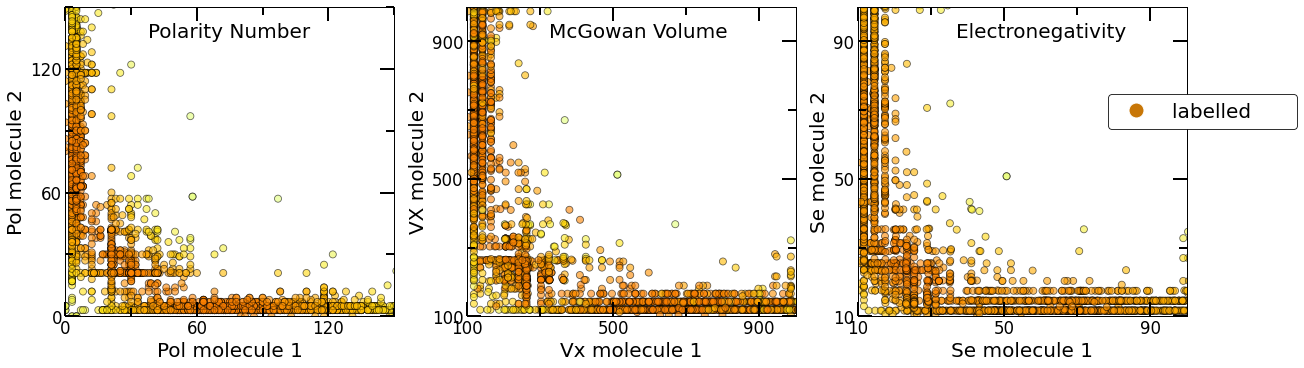

In [72]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from scipy.stats import gaussian_kde
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds

ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experimental COmpounds

ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='labelled      ', 
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle, bbox_to_anchor= (0.73, 0.75) , ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black') 

plt.savefig('/content/drive/My Drive/cocrystal_design-master/figure_7/figure7_lab_scores.png', bbox_inches="tight",  dpi=600)

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


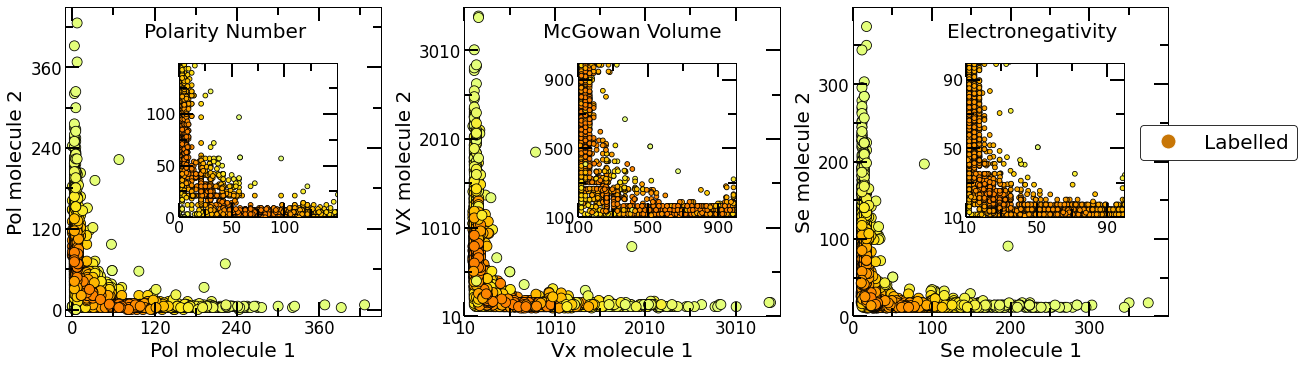

In [73]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(-10, 450)
ax0.set_ylim(-10, 450)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 450, 120)
minor_ticks_x = np.arange(0, 450, 60)
major_ticks_y = np.arange(0, 450, 120)
minor_ticks_y = np.arange(0, 450, 60)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax0.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(0, 150)
sub_axes.set_ylim(0, 150)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150, 50)
minor_ticks_x = np.arange(0, 150, 25)
major_ticks_y = np.arange(0, 150, 50)
minor_ticks_y = np.arange(0, 150, 25)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black', cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(10, 3500)
ax1.set_ylim(10, 3500)
major_ticks_x = np.arange(10,  3500, 1000)
minor_ticks_x = np.arange(10,  3500, 500)
major_ticks_y = np.arange(10, 3500, 1000)
minor_ticks_y = np.arange(10,  3500, 500)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax1.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(100, 1000)
sub_axes.set_ylim(100, 1000)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 400, 100)
minor_ticks_x = np.arange(0, 400, 50)
major_ticks_y = np.arange(0, 400, 100)
minor_ticks_y = np.arange(0, 400, 50)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')
sub_axes = ax2.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(10, 100)
sub_axes.set_ylim(10, 100)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100.1, 40)
minor_ticks_x = np.arange(10, 100.1, 20)
major_ticks_y = np.arange(10, 100.1, 40)
minor_ticks_y = np.arange(10, 100.1, 20)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle,  bbox_to_anchor= (1.44, 0.65), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')

plt.savefig('figure9_lab_scores_inset.png', dpi=600)

In [ ]:
deep_scores= pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/deep_scores_60_epochs.csv')
test_score = pd.DataFrame(deep_scores.iloc[1722:, :].values, columns=['test_score'])
test_score['test_score'][test_score['test_score'] < 0] = 0
unlab = pd.concat([pd.DataFrame(uf_final.comb.values, columns=['Identifier']), pd.DataFrame(test_score.test_score, columns=['test_score'])], axis=1)
combinations = unlab[unlab.test_score> 0.7].Identifier.values

In [95]:
test = uf_final[uf_final.comb.isin(combinations)]
test_all =  uf_final[~uf_final.comb.isin(combinations)]

In [96]:
def feature(feat):
  data = pd.concat([pd.DataFrame(df[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(df[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data['label'] = 'labeled'

  data1 = pd.concat([pd.DataFrame(test[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data1['label'] = 'inliers'

  data2 = pd.concat([pd.DataFrame(test_all[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test_all[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data2['label'] = 'unlabeled'

  data_all = pd.concat([data, data1, data2])
  return data_all

data_all = feature('Pol')

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


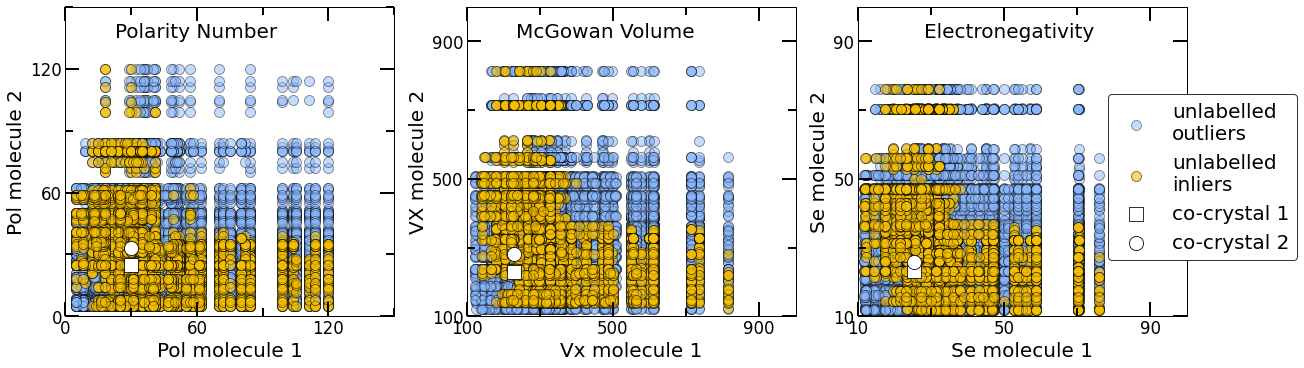

In [97]:
import matplotlib.font_manager
from matplotlib import cm
from scipy.stats import gaussian_kde
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
#newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
data_all = feature('Pol')
data = data_all[data_all.label == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax0.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black' )#, label = 'Unlabelled')
ax0.text(0.15, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds
ax0.scatter(30, 25, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax0.scatter(30, 33, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction = 'in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
data_all = feature('Vx')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']

#x1y1 = np.vstack([x1,y1])
#z = gaussian_kde(x1y1)(x1y1)
ax1.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black')
ax1.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers') #, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.15, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experomental COmpounds
ax1.scatter(227.911, 228.115, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax1.scatter(227.911, 281.964, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True , direction = 'in')
major_ticks_x = np.arange(100, 1000.1, 400)
minor_ticks_x = np.arange(100, 1000.1, 200)
major_ticks_y = np.arange(100, 1000.1, 400)
minor_ticks_y = np.arange(100, 1000.1, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
data_all = feature('Se')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax2.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black', label = 'unlabelled\noutliers' )
ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='unlabelled\ninliers')

ax2.text(0.2, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
ax2.scatter(25.418, 23.183, color='white', s=200, label='co-crystal 1',marker = 's', edgecolors='black')
ax2.scatter(25.418, 25.854, color='white', s=200,marker = 'o', label='co-crystal 2',edgecolors='black')         
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)

ax2.set_yticks(minor_ticks_y, minor=True)
#ax2.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
plt.legend( bbox_to_anchor= (0.73, 0.75), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
#plt.savefig('figure9_unlab.png', dpi=600)

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


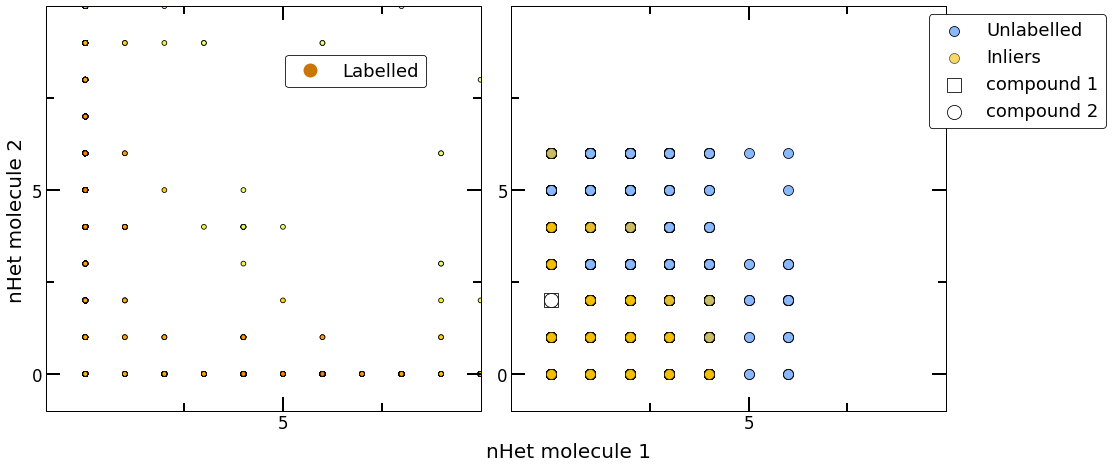

In [98]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


def feature_distribution(descriptor):
  fig, axes = plt.subplots(figsize=(15,6),nrows=1, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
  ax1, ax0= axes.flatten()
  data_all = feature(descriptor)
  data = data_all[data_all.label == 'unlabeled']
  ax0.scatter(data.x, data.y,s=100, alpha=1, color='#8ab8fe', edgecolors='black' , label = 'Unlabelled')
  ax0.axis(aspect='equal')
  ax0.set(adjustable='box')
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.spines['bottom'].set_color('black')
  ax0.spines['top'].set_color('black')
  ax0.spines['right'].set_color('black')
  ax0.spines['left'].set_color('black')
  ax0.axis('on')
  ax0.scatter(data_all[data_all.label == 'inliers']['x'], data_all[data_all.label == 'inliers']['y'], s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')
  
  # Experimental Compounds
  ax0.scatter(uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 1], color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
  ax0.scatter(uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 1], color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.set_xlim(-1, 10)
  ax0.set_ylim(-1, 10)
  ax0.legend(loc= (0.96, 0.7), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')

  x1=data_all[data_all.label == 'labeled']['x']
  y1=data_all[data_all.label == 'labeled']['y']
  x1y1 = np.vstack([x1,y1])
  z = gaussian_kde(x1y1)(x1y1)
  ax1.scatter(x1,y1, edgecolors='black', c=z,  cmap=plt.cm.Wistia, label='Labeled')
  ax1.set_xlim(-1, 10)
  ax1.set_ylim(-1, 10)
  red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
  ax1.legend(handles=red_circle,  loc= (0.55, 0.8), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')


  fig.text(0.5, -0.05, '%s molecule 1'%descriptor, ha='center',fontsize=20 )
  fig.text(-0.02, 0.5, '%s molecule 2'%descriptor, va='center', rotation='vertical', fontsize=20)


  major_ticks_x = np.arange(0, 10, 5)
  minor_ticks_x = np.arange(0, 10, 2.5)
  major_ticks_y = np.arange(0, 10, 5)
  minor_ticks_y = np.arange(0, 10, 2.5)
  for ax in axes.flatten():
    set_spines(ax)
    set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x )
  #fig.tight_layout(pad=3)


def set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x ):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                   top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.xaxis.get_major_ticks()[0].draw = lambda *args:None


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')



feature_distribution('nHet')
#plt.savefig('nHet.png',  dpi=600,rasterized=True,  bbox_inches="tight")

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


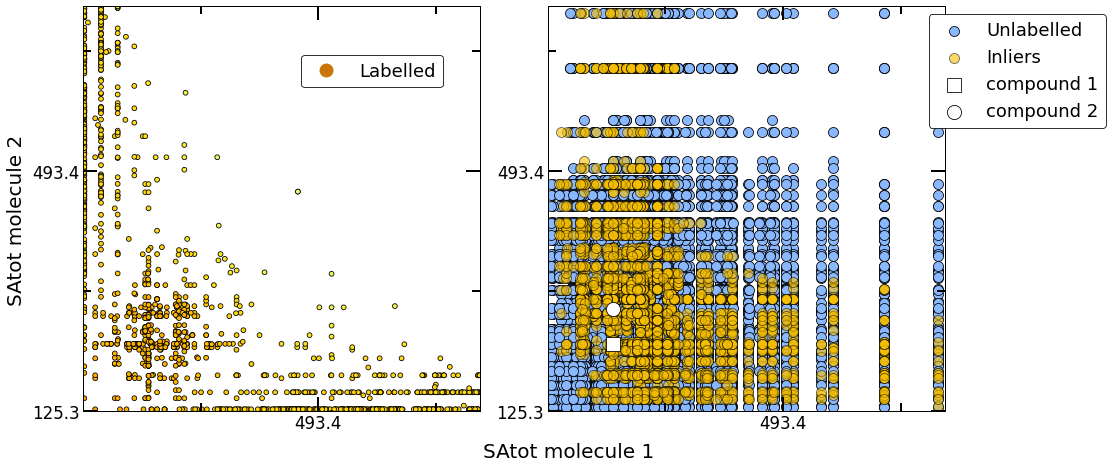

In [99]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


def feature_distribution(descriptor):
  fig, axes = plt.subplots(figsize=(15,6),nrows=1, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
  ax1, ax0= axes.flatten()
  data_all = feature(descriptor)
  data = data_all[data_all.label == 'unlabeled']
  ax0.scatter(data.x, data.y,s=100, alpha=1, color='#8ab8fe', edgecolors='black' , label = 'Unlabelled')
  ax0.axis(aspect='equal')
  ax0.set(adjustable='box')
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.spines['bottom'].set_color('black')
  ax0.spines['top'].set_color('black')
  ax0.spines['right'].set_color('black')
  ax0.spines['left'].set_color('black')
  ax0.axis('on')
  ax0.scatter(data_all[data_all.label == 'inliers']['x'], data_all[data_all.label == 'inliers']['y'], s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')
  
  # Experimental Compounds
  ax0.scatter(uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 1], color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
  ax0.scatter(uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 1], color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.set_xlim(data.min()[0]-5, data.max()[0]+10)
  ax0.set_ylim(data.min()[0]-5, data.max()[0]+10)
  ax0.legend(loc= (0.96, 0.7), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')

  x1=data_all[data_all.label == 'labeled']['x']
  y1=data_all[data_all.label == 'labeled']['y']
  x1y1 = np.vstack([x1,y1])
  z = gaussian_kde(x1y1)(x1y1)
  ax1.scatter(x1,y1, edgecolors='black', c=z,  cmap=plt.cm.Wistia, label='Labeled')
  ax1.set_xlim(data.min()[0]-5, data.max().any()+10)
  ax1.set_ylim(data.min()[0]-5, data.max().any()+10)
  red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
  ax1.legend(handles=red_circle,  loc= (0.55, 0.8), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')


  fig.text(0.5, -0.05, '%s molecule 1'%descriptor, ha='center',fontsize=20 )
  fig.text(-0.02, 0.5, '%s molecule 2'%descriptor, va='center', rotation='vertical', fontsize=20)


  major_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1,data.max().any()/4)
  major_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/4)
  for ax in axes.flatten():
    set_spines(ax)
    set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x )
  #fig.tight_layout(pad=3)


def set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x ):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                   top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.xaxis.get_major_ticks()[0].draw = lambda *args:None


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')



feature_distribution('SAtot')


Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


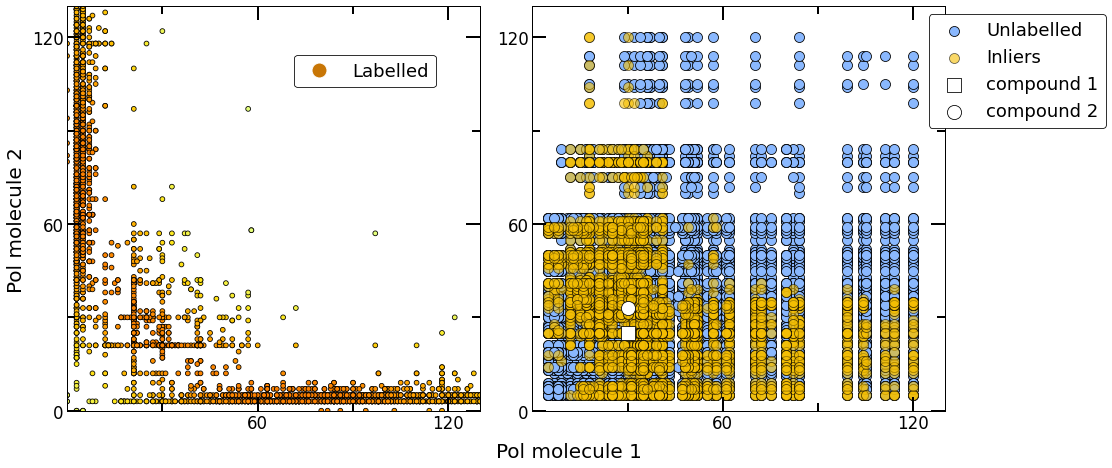

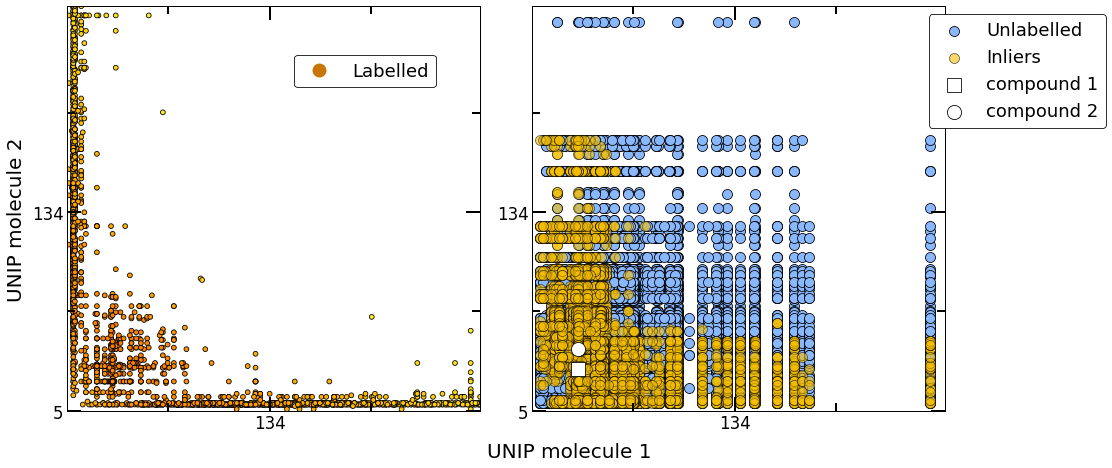

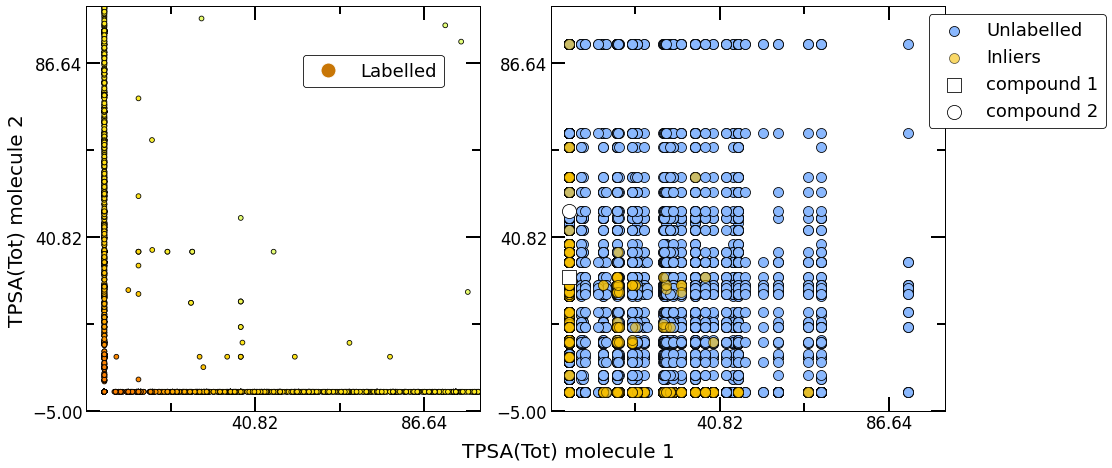

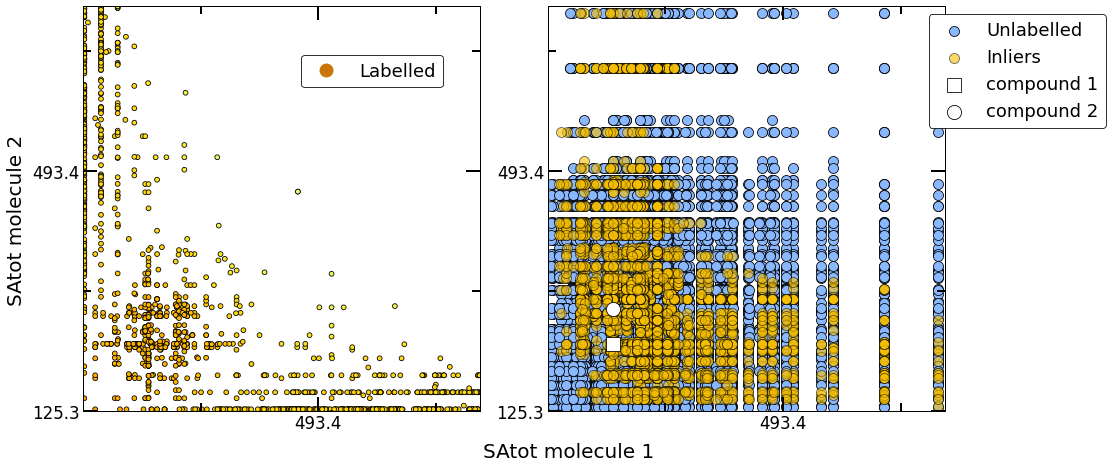

In [100]:
# Polarity Descriptors
polarity_descr = ['Pol', 'UNIP', 'TPSA(Tot)', 'SAtot']

for i in polarity_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


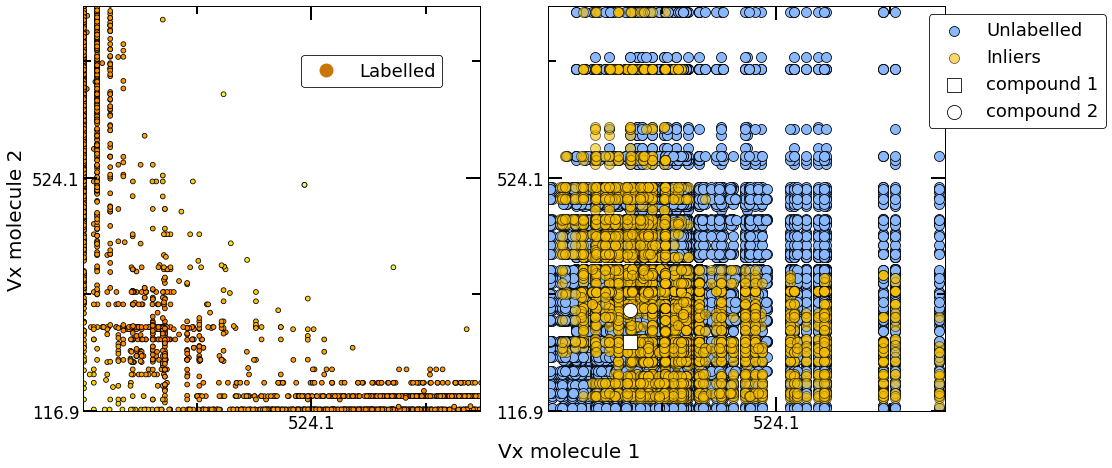

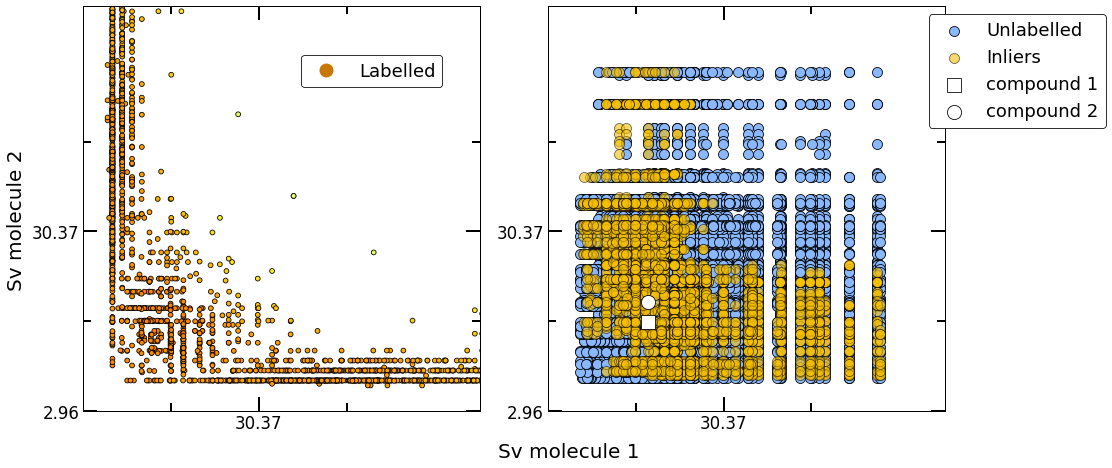

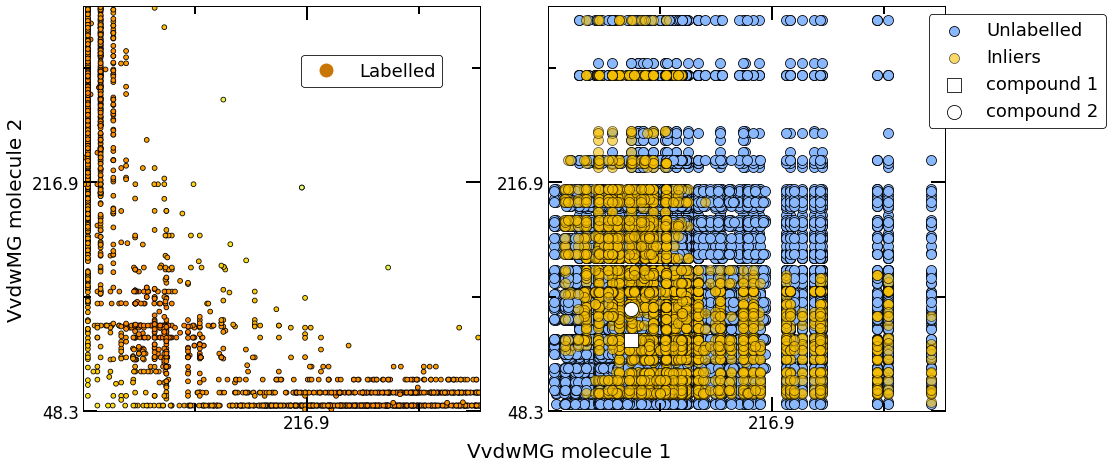

In [101]:
# Size descriptors
size_descr = ['Vx', 'Sv', 'VvdwMG']

for i in size_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


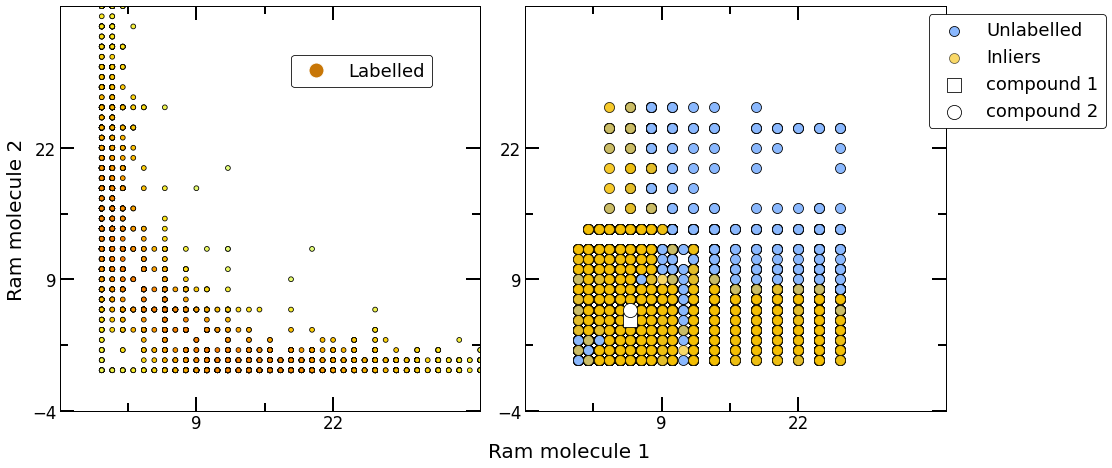

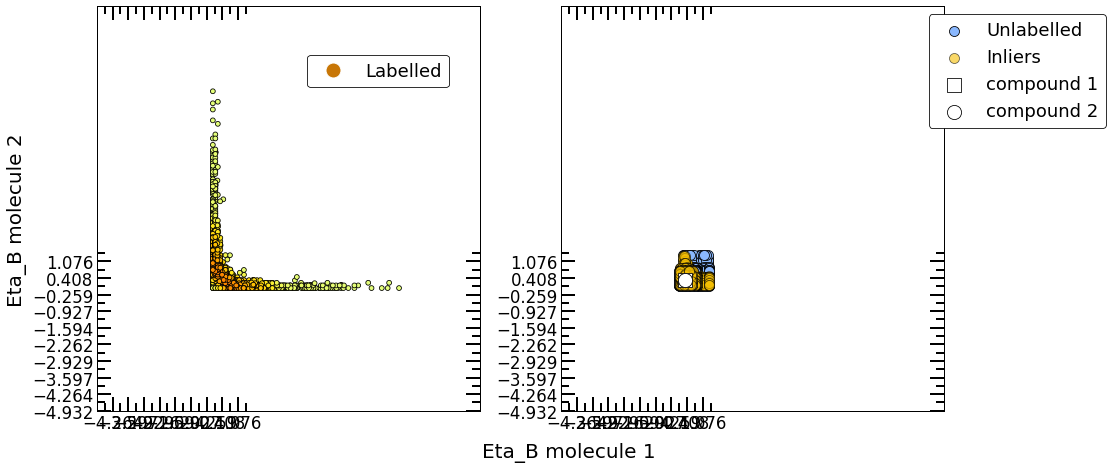

In [102]:
# Shape descriptors
shape_descr = ['Ram', 'Eta_B' ]

for i in shape_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


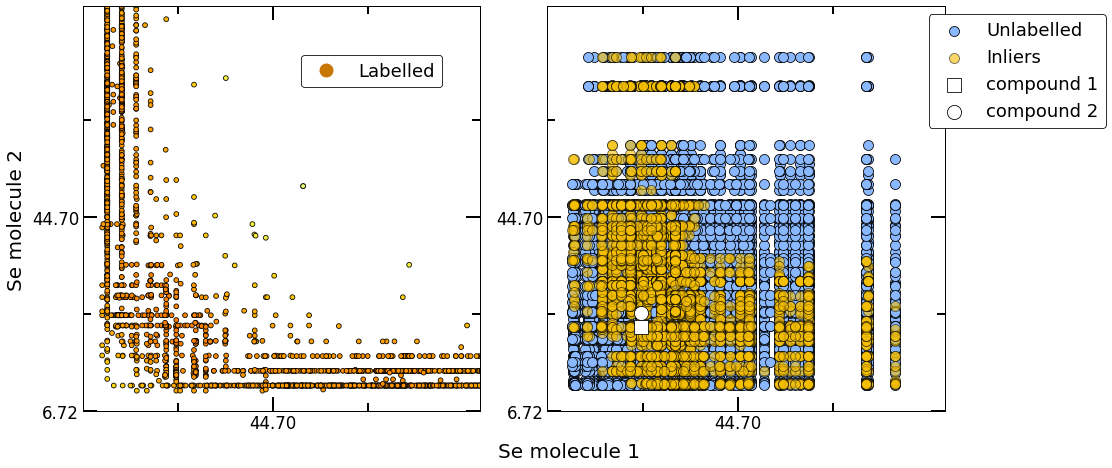

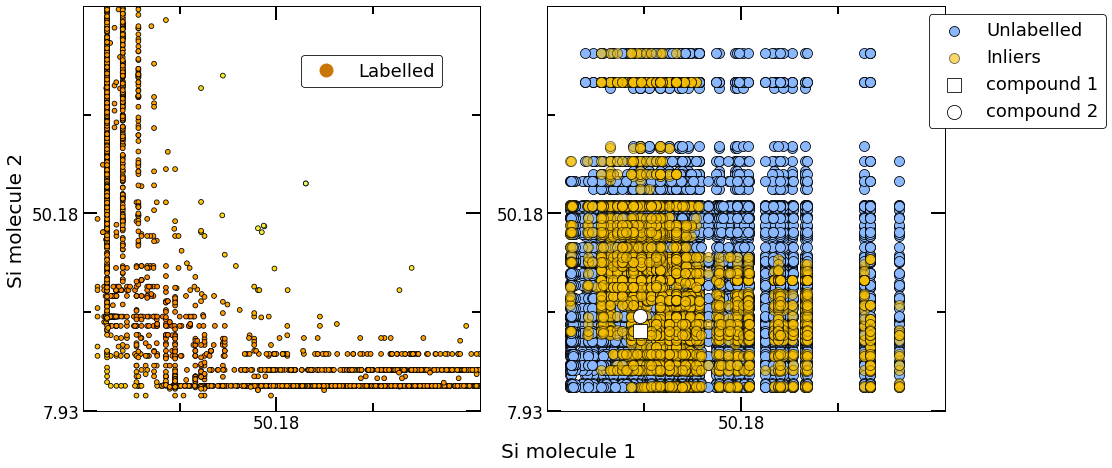

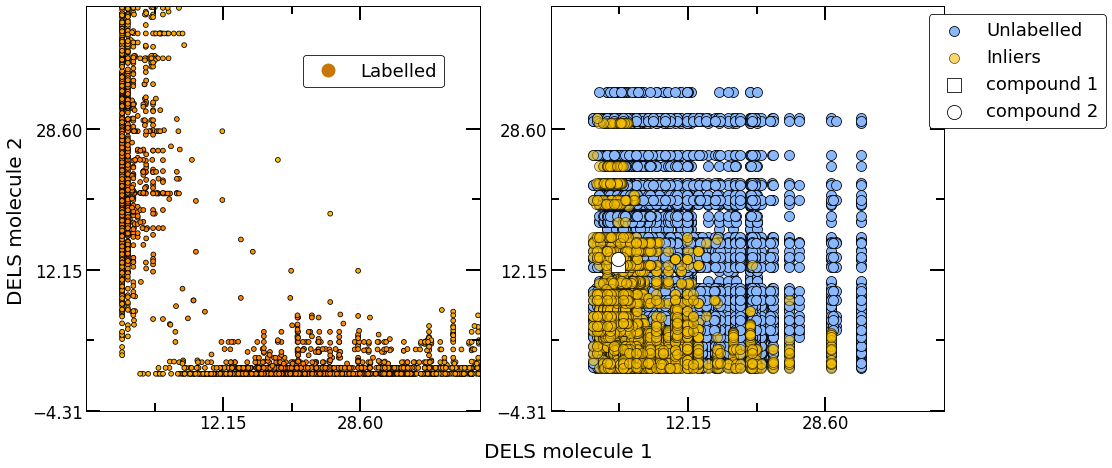

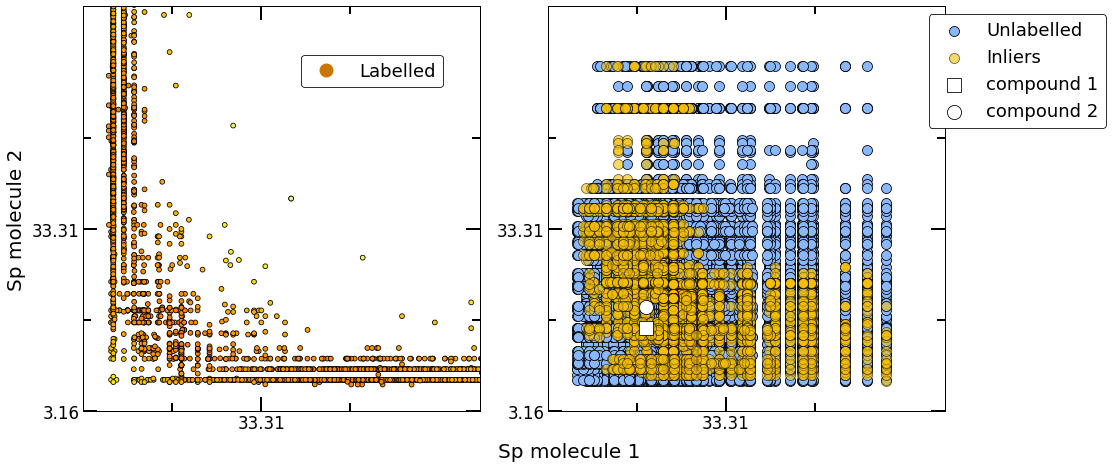

In [103]:
# Electronic properties descriptors
electr_descr = ['Se', 'Si', 'DELS', 'Sp']

for i in electr_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


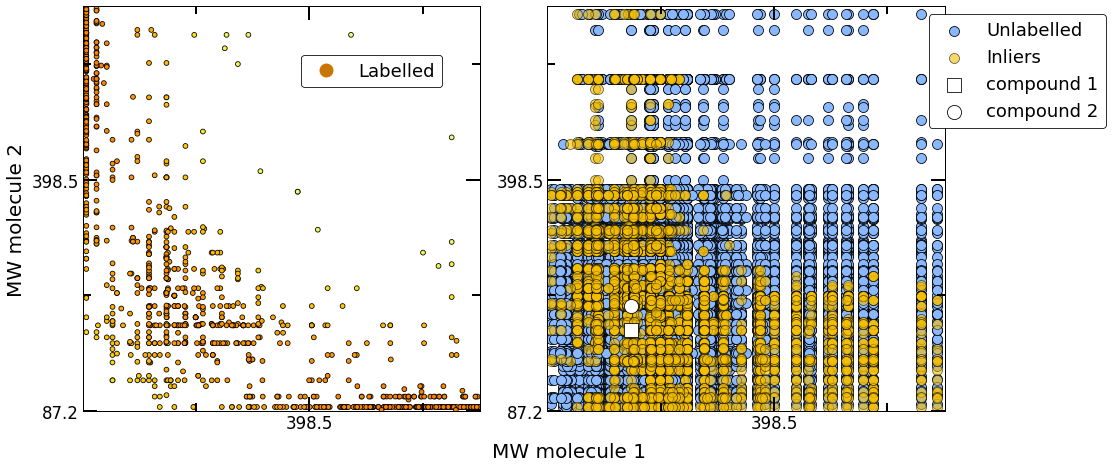

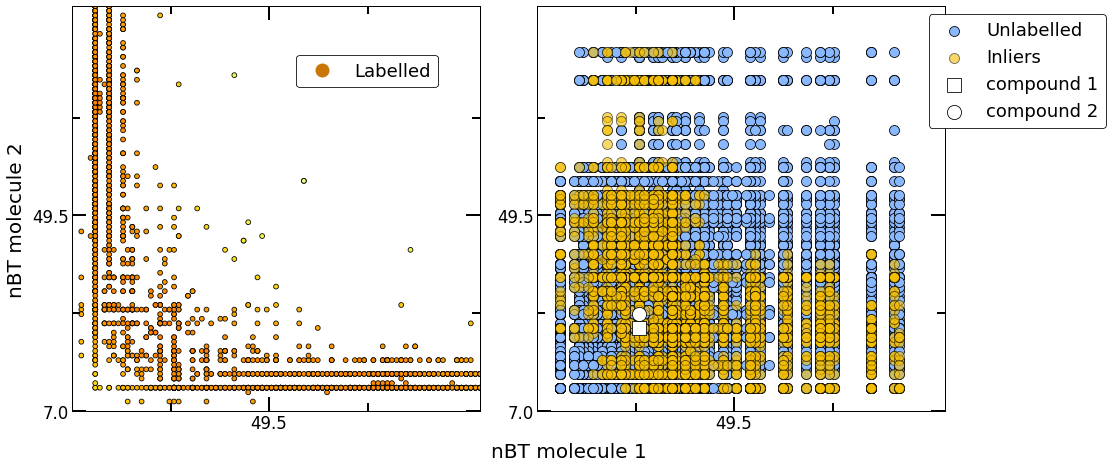

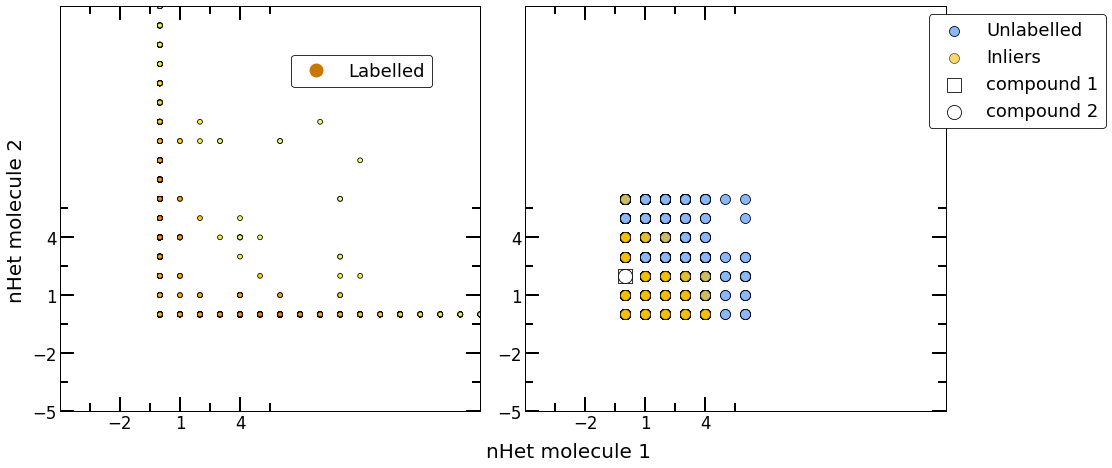

In [104]:
# General descriptors
general_descr =['MW', 'nBT', 'nHet']

for i in general_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")